"Third" Light
============================

Setup
-----------------------------

As always, let's do imports and initialize a logger and a new bundle.  See [Building a System](building_a_system.html) for more details.

In [1]:
%matplotlib inline

In [2]:
import phoebe
from phoebe import u # units
import numpy as np
import matplotlib.pyplot as plt

logger = phoebe.logger()

b = phoebe.default_binary()

Relevant Parameters
-----------------------

The 'l3' parameter describes how much third light exists in a given passband.  Since this is passband dependent and only used for flux measurments - it does not yet exist for a new empty Bundle.

In [3]:
b.filter(qualifier='l3')

<ParameterSet: EMPTY>

So let's add a LC dataset

In [4]:
b.add_dataset('lc', times=np.linspace(0,1,101), dataset='lc01')

<ParameterSet: 15 parameters | contexts: compute, dataset>

We now see that the LC dataset created 'l3' parameters for each of the stars in the system hierarchy

In [5]:
b.filter(qualifier='l3')

<ParameterSet: 1 parameters>

We can also see that these belong in the 'dataset' section and in the 'lc_dep' kind.  This just means that these are passband-dependent parameters.

This also means that 'l3' will be relevant (and will be created) for RV datasets (when using the 'flux-weighted' method).

In [6]:
print b['l3@lc01']

Parameter: l3@lc01@dataset
                       Qualifier: l3
                     Description: Third light
                           Value: 0.0 W / m3
                  Constrained by: 
                      Constrains: None
                      Related to: None



Influence on Light Curves (Fluxes)
-----------------------------------------

"Third" light is simply additional flux added to the light curve from some external source - whether it be crowding from a background object, light from the sky, or an extra component in the system that is unaccounted for in the system hierarchy.

To see this we'll compare a light curve with and without "third" light.

In [7]:
b.run_compute(irrad_method='none', model='no_third_light')

<ParameterSet: 2 parameters | qualifiers: fluxes, times>

In [8]:
b['l3@lc01'] = 5

In [9]:
b.run_compute(irrad_method='none', model='with_third_light')

<ParameterSet: 2 parameters | qualifiers: fluxes, times>

As expected, adding 5 W/m^3 of third light simply shifts the light curve up by that exact same amount.

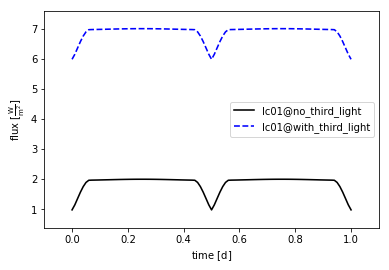

In [11]:
afig, mplfig = b['lc01'].plot(model='no_third_light')
afig, mplfig = b['lc01'].plot(model='with_third_light', legend=True, show=True)

Influence on Meshes (Intensities)
-----------------------------------------

"Third" light does not affect the intensities stored in the mesh (including those in relative units).  In other words, like [distance](distance), "third" light only scales the fluxes.

NOTE: this is different than pblums which **DO** affect the relative intensities.  Again, see the [pblum tutorial](pblum) for more details.

To see this we can run both of our models again and look at the values of the intensities in the mesh.

In [12]:
b.add_dataset('mesh', times=[0], dataset='mesh01', columns=['intensities@lc01', 'abs_intensities@lc01'])

<ParameterSet: 4 parameters | contexts: compute, dataset>

In [13]:
b['l3@lc01'] = 0.0

In [14]:
b.run_compute(irrad_method='none', model='no_third_light')

Fri, 05 Oct 2018 13:22 BUNDLE       WARNING overwriting model: no_third_light


<ParameterSet: 12 parameters | kinds: mesh, lc>

In [15]:
b['l3@lc01'] = 5

In [16]:
b.run_compute(model='with_third_light')

Fri, 05 Oct 2018 13:23 BUNDLE       WARNING overwriting model: with_third_light


<ParameterSet: 12 parameters | kinds: mesh, lc>

In [19]:
print "no_third_light abs_intensities: ", np.nanmean(b.get_value(qualifier='abs_intensities', component='primary', dataset='lc01', model='no_third_light'))
print "with_third_light abs_intensities: ", np.nanmean(b.get_value(qualifier='abs_intensities', component='primary', dataset='lc01', model='with_third_light'))

 no_third_light abs_intensities:  27863579625587.58
with_third_light abs_intensities:  28289195323487.04


In [21]:
print "no_third_light intensities: ", np.nanmean(b.get_value(qualifier='intensities', component='primary', dataset='lc01', model='no_third_light'))
print "with_third_light intensities: ", np.nanmean(b.get_value(qualifier='intensities', component='primary', dataset='lc01', model='with_third_light'))

no_third_light intensities:  6.335774930400718e-12
with_third_light intensities:  6.432553783117118e-12
